In [1]:
import os
import cv2
import itertools
import librosa
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import warnings
import zipfile
from io import BytesIO
from tqdm import tqdm
from glob import glob
from PIL import Image
from google.colab import files
from google.cloud import storage
warnings.filterwarnings('ignore')

# Pytorch
import torch
import torchaudio
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchaudio.transforms import MelSpectrogram, MFCC, SpectralCentroid

# Hugging Face Transformers
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer,  Wav2Vec2Config, Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Hardware report packages
import gc
import types
import pkg_resources

# Seed for reproducibility
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [2]:
device = 'cuda'

In [3]:
!find /content/sample_data/ -type f -exec rm {} +

### Import Data

In [4]:
firts_time = True

In [5]:
if firts_time:
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))


Saving projetos-aleatorios-379913-61df4a1c249e.json to projetos-aleatorios-379913-61df4a1c249e.json
User uploaded file "projetos-aleatorios-379913-61df4a1c249e.json" with length 2372 bytes


In [6]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/projetos-aleatorios-379913-61df4a1c249e.json'

In [7]:
storage_client = storage.Client()

In [8]:
bucket_name = 'projeto_musical'
rar_file_name = 'labels.csv'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [9]:
ajuste = pd.read_csv('labels.csv')

In [10]:
audio_folder = 'chords/variation_chord_audio/'

In [11]:
ajuste['file_path'] = ajuste['file_name'].apply(lambda x: os.path.join(audio_folder, x))
ajuste['chord_idx'] = pd.Categorical(ajuste['chord']).codes

In [16]:
ajuste.to_csv('base_dimensoes.csv')

In [12]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_data_var.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [13]:
with zipfile.ZipFile('audio_data_var.zip', 'r') as zip_ref:
    # Extraindo todos os arquivos
    zip_ref.extractall('/content')

### Import dos dados e cálculo do desvio

In [14]:
labels = pd.read_csv('audio_data.csv')
labels.drop(columns='Unnamed: 0',inplace=True)

In [15]:
labels

,file_path,chord_idx
0,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
1,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
2,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
3,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
4,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
...,...,...
2569391,chords/variation_chord_audio_white_noise/t_DsG...,369
2569392,chords/variation_chord_audio_white_noise/t_DsG...,369
2569393,chords/variation_chord_audio_white_noise/t_DsG...,369
2569394,chords/variation_chord_audio_white_noise/t_DsG...,369


In [17]:
analise = labels['chord_idx'].value_counts()
analise

186    14127
20     13974
109    13647
303    13644
149    13179
       ...  
181     2757
120     2712
92      2706
169     2706
197     2478
Name: chord_idx, Length: 373, dtype: int64

In [18]:
print(
    f'Media: {round(analise.mean(),2)}',
    f'Percentil 25: {round(analise.quantile(0.25),2)}',
    f'Mediana: {round(analise.median(),2)}',
    f'Percentil 75: {round(analise.quantile(0.75),2)}',
    f'Desvio Padrão: {round(analise.std(),2)}',
    f'Moda: {analise.mode()}',
    f'Max: {analise.max()}',
    f'Min: {analise.min()}',
    sep='\n'
)

Media: 6888.46
Percentil 25: 5475.0
Mediana: 6789.0
Percentil 75: 8031.0
Desvio Padrão: 2036.58
Moda: 0    4968
Name: chord_idx, dtype: int64
Max: 14127
Min: 2478


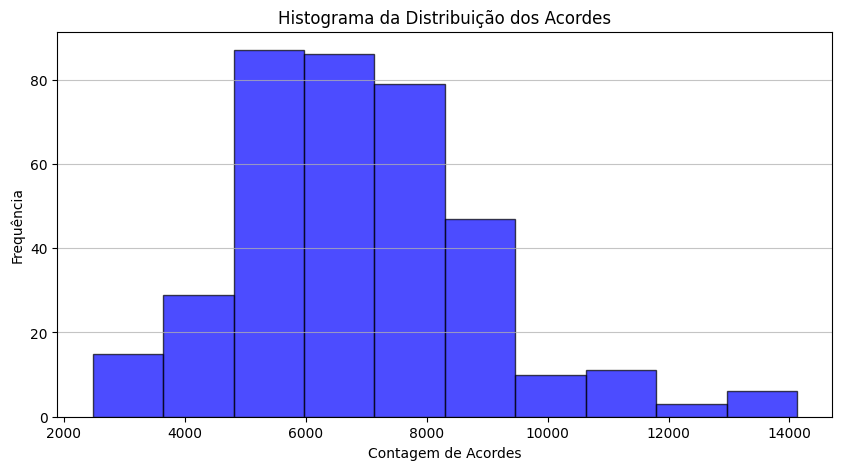

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(analise, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [20]:
target_instance = analise.quantile(0.6)
target_std = round(analise.std(),0)
# data_aug_rate_down = analise.apply(lambda x: target_std + round(target_std * (1-target_instance/x),0) if x > target_instance else 0)
data_aug_rate_down = analise.apply(lambda x: target_std + round(target_std * (1-target_instance/x) * 1.4,0) if x > target_instance else 0)

In [21]:
for label, group in labels.groupby('chord_idx'):
    rate = data_aug_rate_down[label]
    if rate > 0:
        # Seleciona aleatoriamente 'rate' amostras para remover
        samples_to_remove = group.sample(n=int(rate))
        # Remove as amostras selecionadas do dataframe original
        labels = labels.drop(samples_to_remove.index)

labels.reset_index(drop=True, inplace=True)

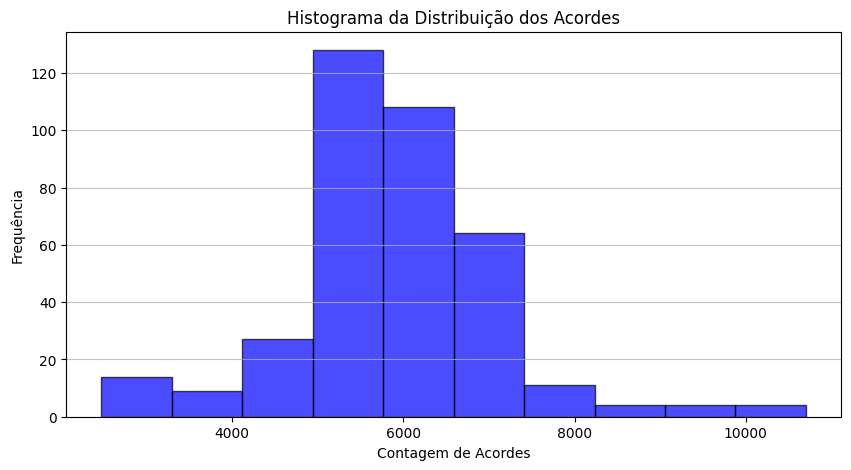

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(labels['chord_idx'].value_counts(), bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [24]:
# Lista de arquivos com erro
files_with_error = [
    "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3",
    # Adicione mais caminhos de arquivos aqui, se necessário
]

# Remover as linhas do DataFrame que contêm os caminhos dos arquivos com erro
labels = labels[~labels['file_path'].isin(files_with_error)]

### Funções do modelo

In [25]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [26]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [27]:
def inicializa_modelo_wav2vec(num_classes, use_pretrained=True, freeze_feature_extractor=True):
    # Carregar a configuração pré-treinada
    config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h")
    config.num_labels = num_classes  # Ajustar o número de classes na última camada

    # Adicionar um atributo personalizado para pooling_mode, se necessário
    config.pooling_mode = "mean"  # Ou qualquer outro valor padrão relevante para o seu caso

    # Criar uma nova instância do modelo personalizado
    model = Wav2Vec2ForSpeechClassification(config)

    if use_pretrained:
        # Certifique-se de carregar os pesos pré-treinados apenas para o modelo base Wav2Vec2
        base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        model.wav2vec2 = base_model
        model.init_weights()  # Inicializar apenas os pesos da nova cabeça de classificação

    # Congelar as camadas do extrator de características, se necessário
    if freeze_feature_extractor:
        model.freeze_feature_extractor()

    # Carregar o processor
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    return model, processor

In [28]:
class AudioDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['chord_idx']

        # Carregar e processar o áudio
        y, sr = librosa.load(audio_path, sr=16000)
        if len(y) > sr:  # Se o áudio for mais longo que 1 segundo
            y = y[:sr]
        elif len(y) < sr:  # Se o áudio for mais curto que 1 segundo
            padding = sr - len(y)
            y = np.pad(y, (0, padding), 'constant')

        # Processa com wav2vec 2.0
        inputs = self.processor(y, sampling_rate=sr, return_tensors="pt", padding=True)

        return inputs.input_values.squeeze(), torch.tensor(label)

In [29]:
# Função para calcular erro em treino e validação durante o treinamento
class CalculaMetricas(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
# Listas para erro e acurácia em treino
total_loss_train, total_acc_train = [],[]

def treina_modelo_wav2vec(treino_loader, model, criterion, optimizer, epoch, device):
    model.train()
    train_loss = CalculaMetricas()
    train_acc = CalculaMetricas()

    for i, (inputs, labels) in enumerate(treino_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # O modelo `wav2vec 2.0` espera os inputs no formato (batch_size, sequence_length)
        outputs = model(inputs).logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_acc.update(torch.sum(preds == labels).item() / inputs.size(0))
        train_loss.update(loss.item())

        if (i + 1) % 100 == 0:
            print(f'[epoch {epoch}], [iter {i + 1} / {len(treino_loader)}], [train loss {train_loss.avg:.5f}], [train acc {train_acc.avg:.5f}]')

    return train_loss.avg, train_acc.avg

In [31]:
total_loss_val, total_acc_val = [],[]
def valida_modelo_wav2vec(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = CalculaMetricas()
    val_acc = CalculaMetricas()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits

            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)

            val_acc.update(torch.sum(preds == labels).item() / inputs.size(0))
            val_loss.update(loss.item())

    print(f'------------------------------------------------------------')
    print(f'[Epoch {epoch}], [Val Loss {val_loss.avg:.5f}], [Val Acc {val_acc.avg:.5f}]')
    print(f'------------------------------------------------------------')

    return val_loss.avg, val_acc.avg

### Editando dataset

In [32]:
y = labels['chord_idx']
_, df_validacao = train_test_split(labels, test_size = 0.2, random_state = 101, stratify = y)

In [33]:
df_validacao.shape

(439882, 2)

In [34]:
indices_validacao = set(df_validacao.index)

# Agora definimos uma função que verifica se o índice de uma linha está nesse conjunto
def get_train_val_label(row_index):
    return 'val' if row_index in indices_validacao else 'train'

# Aplicamos essa função a cada linha do DataFrame 'labels'
labels['train_or_val'] = labels.index.map(get_train_val_label)


In [35]:
labels[labels['train_or_val'] == 'train']

,file_path,chord_idx,train_or_val
0,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
1,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
2,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
3,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
6,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
...,...,...,...
2199408,chords/variation_chord_audio_white_noise/t_DsG...,369,train
2199409,chords/variation_chord_audio_white_noise/t_DsG...,369,train
2199410,chords/variation_chord_audio_white_noise/t_DsG...,369,train
2199411,chords/variation_chord_audio_white_noise/t_DsG...,369,train


In [36]:
# Filtra as linhas de treino
df_treino = labels[labels['train_or_val'] == 'train']

In [37]:
print(len(df_treino))
print(len(df_validacao))

1759528
439882


In [38]:
df_treino['chord_idx'].value_counts()

186    8561
20     8451
109    8218
303    8216
149    7886
       ... 
181    2206
120    2170
169    2165
92     2165
197    1982
Name: chord_idx, Length: 373, dtype: int64

In [39]:
df_validacao['chord_idx'].value_counts()

186    2140
20     2113
303    2054
109    2054
149    1972
       ... 
227     551
120     542
92      541
169     541
197     496
Name: chord_idx, Length: 373, dtype: int64

In [40]:
# Podemos dividir o conjunto de validação em um conjunto de validação e um conjunto de teste
df_validacao, df_teste = train_test_split(df_validacao, test_size = 0.5)

In [41]:
# Reset do índice
df_validacao = df_validacao.reset_index()
df_teste = df_teste.reset_index()

In [42]:
df_validacao.shape

(219941, 3)

In [43]:
df_teste.shape

(219941, 3)

#### Inicializando modelo

In [44]:
num_classes = 373

In [45]:
model_wav, processor = inicializa_modelo_wav2vec(num_classes, True, True)
model = model_wav.to(device)

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

#### Carregando Dataloader

In [46]:
# Organiza e transforma os dados de treino
set_treino = AudioDataset(df_treino, processor)
loader_treino = DataLoader(set_treino, batch_size = 64, shuffle = True, num_workers = 4)

In [47]:
# O mesmo em validação
set_val = AudioDataset(df_validacao, processor)
loader_val = DataLoader(set_val, batch_size = 64, shuffle = False, num_workers = 4)

In [48]:
# O mesmo em teste
set_teste = AudioDataset(df_teste, processor)
loader_teste = DataLoader(set_teste, batch_size = 64, shuffle = False, num_workers = 4)

In [49]:
# Usaremos o otimizador Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-5)

In [50]:
# Usaremos cross entropy loss como função de perda
criterion = nn.CrossEntropyLoss().to(device)

In [51]:
bucket_name = 'projeto_musical'
rar_file_name = 'model_wave2seq_e_freeze_10_v1.pth'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [53]:
checkpoint = torch.load(f'model_wave2seq_e_freeze_13_v1.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
del model
del model_wav
del set_treino, set_val, set_teste
del loader_treino, loader_val, loader_teste
del optimizer
del criterion

#### Treinamento

In [59]:
# Hiperparâmetros
epoch_num = 15
best_val_acc = 0

In [ ]:
%%time
for epoch in range(11, epoch_num + 1):

    # Execute a função de treino
    loss_train, acc_train = treina_modelo_wav2vec(loader_treino, model, criterion, optimizer, epoch, device)


    # Executa a função de validação
    loss_val, acc_val = valida_modelo_wav2vec(loader_val, model, criterion, device, epoch)

    # Calcula as métricas
    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # Verifica a acurácia em validação
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Melhor Resultado: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

    #torch.save(model.state_dict(), f'model_wave2seq_e_{epoch}.pth')
    archive_name = f'model_wave2seq_e_freeze_{epoch}_v1.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, archive_name)

    blob = bucket.blob(archive_name)
    blob.upload_from_filename(archive_name)
    print(f'Arquivo {archive_name} enviado com sucesso para o bucket.')

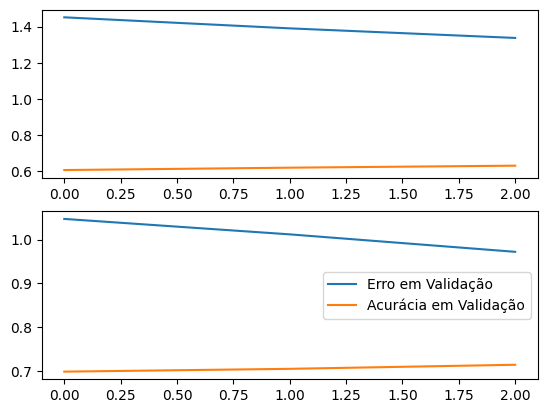

In [61]:
# Plot
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Erro em Treino')
fig1.plot(total_acc_train, label = 'Acurácia em Treino')
fig2.plot(total_loss_val, label = 'Erro em Validação')
fig2.plot(total_acc_val, label = 'Acurácia em Validação')
plt.legend()
plt.show()

### Avaliação do Modelo

In [62]:
def avalia_modelo(loader_teste, model, device):
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0

    with torch.no_grad():  # No need to track the gradients
        print('Começando:')
        for batch_index, (inputs, labels) in enumerate(loader_teste):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Obter previsões do modelo
            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            # Atualizar contadores
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_index+1 % 100 == 0:
              print(f'Batch: {batch_index+1}/{len(loader_teste)} - Correct Predictions: {round(correct/total * 100,2)}')

    acuracia = 100 * correct / total
    print(f'Acurácia nos dados de teste: {acuracia:.2f}%')

    return acuracia

In [63]:
# Avaliar o modelo
acuracia_teste = avalia_modelo(loader_teste, model, device)

Começando:
Acurácia nos dados de teste: 71.02%


### Previsão

In [ ]:
from sklearn.metrics import classification_report
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, AutoConfig
import torch

In [ ]:
checkpoint_path = 'model_wave2seq_e_freeze_5_v1.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Supondo que você tenha o processor salvo ou você precisa instanciar um novo
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

In [ ]:
def speech_file_to_array_fn(path, target_sampling_rate):
    speech_array, sampling_rate = torchaudio.load(path)
    if sampling_rate != target_sampling_rate:
        speech_array = librosa.resample(speech_array.numpy(), orig_sr=sampling_rate, target_sr=target_sampling_rate)
    return speech_array.squeeze()

def predict(path, label, target_sampling_rate):
    # Processa o arquivo de áudio
    speech = speech_file_to_array_fn(path, target_sampling_rate)
    features = processor(speech, sampling_rate=target_sampling_rate, return_tensors="pt", padding=True)

    # Mova as features para o mesmo dispositivo do modelo
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    # Faça a predição usando o modelo
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    # Obtenha o ID da predição
    pred_id = torch.argmax(logits, dim=-1).item()
    return pred_id, label

In [ ]:
pip install pytube moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 789.8 kB/s eta 0:00:00


In [ ]:
from pytube import YouTube
from moviepy.editor import AudioFileClip

def download_and_cut_youtube_audio(url, start_time, end_time, output_filename):
    """
    Baixa o áudio de um vídeo do YouTube e corta um segmento especificado.

    Args:
    - url (str): URL do vídeo do YouTube.
    - start_time (int): Início do corte em segundos.
    - end_time (int): Fim do corte em segundos.
    - output_filename (str): Nome do arquivo de saída para o áudio cortado.
    """
    # Baixar o áudio do vídeo do YouTube
    yt = YouTube(url)
    stream = yt.streams.filter(only_audio=True).first()
    stream.download(output_path='.', filename='temp_audio.mp4')

    # Carregar o arquivo de áudio baixado e cortar o segmento desejado
    audio_clip = AudioFileClip('temp_audio.mp4').subclip(start_time, end_time)

    # Salvar o segmento de áudio cortado em um arquivo
    audio_clip.write_audiofile(output_filename)

    # Fechar o clip para liberar recursos
    audio_clip.close()

In [ ]:
# Cria um dicionário mapeando acordes para índices únicos
chord_to_idx = ajuste.drop_duplicates(subset=['chord']).set_index('chord')['chord_idx'].to_dict()

# Inverte o dicionário para mapear índices para acordes
idx_to_chord = {idx: chord for chord, idx in chord_to_idx.items()}

# Cria a lista de nomes de acordes ordenados pelos índices de acordes
label_names = [idx_to_chord[idx] for idx in sorted(idx_to_chord)]

# Confirma se o label_names está completo e corretamente ordenado
# assert len(label_names) == len(idx_to_chord) == max(idx_to_chord.keys()) + 1

In [ ]:
from IPython.display import Audio, display
import torch.nn.functional as F

In [ ]:
def load_and_resample(path, new_sr=16000):
    waveform, old_sr = torchaudio.load(path)
    if old_sr != new_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=old_sr, new_freq=new_sr)
        waveform = resampler(waveform)
    return waveform

def process_audio_and_predict(audio_path, label, target_sampling_rate):
    # Carregar e processar o áudio
    y = load_and_resample(audio_path, target_sampling_rate)
    y, sr = librosa.load(audio_path, sr=target_sampling_rate)

    if len(y) > target_sampling_rate:  # Se o áudio for mais longo que 1 segundo
        y = y[:target_sampling_rate]
    elif len(y) < target_sampling_rate:  # Se o áudio for mais curto que 1 segundo
        padding = target_sampling_rate - len(y)
        y = np.pad(y, (0, padding), 'constant')

    # Processa com wav2vec 2.0
    inputs = processor(y, sampling_rate=target_sampling_rate, return_tensors="pt", padding=True)
    inputs = inputs.input_values.to(device)


    # Obter logits do modelo
    with torch.no_grad():
        logits = model(inputs).logits

    # Converter logits para probabilidades e então para rótulos e pontuações
    probs = torch.nn.functional.softmax(logits, dim=-1)
    scores, predicted_indices = torch.max(probs, dim=1)
    predicted_labels = [label_names[idx] for idx in predicted_indices.cpu().numpy()]

    # Criar DataFrame para visualização
    predictions = pd.DataFrame({
        'Label': predicted_labels,
        'Score': [f"{score.item() * 100:.1f}%" for score in scores]
    })

    # Exibir áudio e previsões
    display(Audio(y, rate=target_sampling_rate))
    display(predictions)

    # Retornar rótulos e pontuações como uma lista de dicionários
    #return [{"Label": label, "Score": score.item()} for label, score in zip(predicted_labels, scores)]


In [ ]:
def load_and_resample(path, new_sr=16000):
    waveform, old_sr = torchaudio.load(path)
    if old_sr != new_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=old_sr, new_freq=new_sr)
        waveform = resampler(waveform)
    return waveform

def process_audio_and_predict(audio_path, label, target_sampling_rate):
    # Carregar e processar o áudio
    y = load_and_resample(audio_path, target_sampling_rate)
    # y, sr = librosa.load(audio_path, sr=target_sampling_rate)

def process_audio_and_predict(audio_path, target_sampling_rate):
    # Carregar e processar o áudio
    y, sr = librosa.load(audio_path, sr=target_sampling_rate)
    if len(y) > target_sampling_rate:  # Se o áudio for mais longo que 1 segundo
        y = y[:target_sampling_rate]
    elif len(y) < target_sampling_rate:  # Se o áudio for mais curto que 1 segundo
        padding = target_sampling_rate - len(y)
        y = np.pad(y, (0, padding), 'constant')

    # Processa com wav2vec 2.0
    inputs = processor(y, sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = inputs.input_values.to(device)

    # Obter logits do modelo
    with torch.no_grad():
        logits = model(inputs).logits

    # Obter as top 5 probabilidades e índices
    probs = F.softmax(logits, dim=-1)
    top_probs, top_indices = probs.topk(5)

    # Converter para rótulos e pontuações
    predicted_labels = [label_names[idx] for idx in top_indices[0].cpu().numpy()]
    scores = top_probs[0].cpu().numpy() * 100  # Convertendo para porcentagem

    # Criar DataFrame para visualização
    predictions = pd.DataFrame({
        'Label': predicted_labels,
        'Score': [f"{score:.1f}%" for score in scores]
    })

    # Exibir áudio e previsões
    display(Audio(y, rate=target_sampling_rate))
    display(predictions)

    return predictions.to_dict('records')

In [ ]:
download_and_cut_youtube_audio(
    url='https://www.youtube.com/watch?v=fWtbrrmha-k',
    start_time=169,
    end_time=170,
    output_filename='audio_slice.mp3'
) # esse foi legal

chunk: 100%|██████████| 1/1 [03:45<00:00, 225.66s/it, now=None]

MoviePy - Writing audio in audio_slice.mp3



chunk: 100%|██████████| 1/1 [03:45<00:00, 225.75s/it, now=None]

MoviePy - Done.


In [ ]:
download_and_cut_youtube_audio(
    url='https://www.youtube.com/watch?v=fWtbrrmha-k',
    start_time=167,
    end_time=168,
    output_filename='audio_slice.mp3'
) # esse foi legal

In [ ]:
path_to_audio_file = 'audio_slice.mp3'
target_sampling_rate = 16000  # Ou qualquer que seja a taxa de amostragem esperada pelo seu modelo

# Obtenha as logits do modelo
logits = process_audio_and_predict(path_to_audio_file, target_sampling_rate)

,Label,Score
0,B9b5,2.4%
1,C#7#5,2.3%
2,A#m(maj7),1.8%
3,C#aug,1.6%
4,C#9#5,1.6%


In [ ]:
logits = process_audio_and_predict(labels['file_path'][32282], target_sampling_rate)

,Label,Score
0,G#dim7,42.4%
1,Ddim7,29.3%
2,Fdim7,11.1%
3,Bdim7,8.3%
4,Ddim,7.8%


In [ ]:
ajuste[ajuste['chord'] == 'D']

,file_name,tuning,details,clean,chord,file_path,chord_idx
3725,t_DADGBE_guitarD5_Fsfast400232DADGBE.mp3,DADGBE,D5_Fsfast400232,D5_Fsfast400232,D,chords/variation_chord_audio/t_DADGBE_guitarD5...,166
4141,t_DADGBE_guitarDfast000232DADGBE.mp3,DADGBE,Dfast000232,Dfast000232,D,chords/variation_chord_audio/t_DADGBE_guitarDf...,166
4142,t_DADGBE_guitarDfast000232DADGBEv.mp3,DADGBE,Dfast000232v,Dfast000232v,D,chords/variation_chord_audio/t_DADGBE_guitarDf...,166
4143,t_DADGBE_guitarDfast00423xDADGBEv.mp3,DADGBE,Dfast00423xv,Dfast00423xv,D,chords/variation_chord_audio/t_DADGBE_guitarDf...,166
4144,t_DADGBE_guitarDfast0042x2DADGBEv.mp3,DADGBE,Dfast0042x2v,Dfast0042x2v,D,chords/variation_chord_audio/t_DADGBE_guitarDf...,166
...,...,...,...,...,...,...,...
32281,t_EADGBE_guitarDstrumx54232v.mp3,EADGBE,Dstrumx54232v,Dstrumx54232v,D,chords/variation_chord_audio/t_EADGBE_guitarDs...,166
32282,t_EADGBE_guitarDstrumx57775v.mp3,EADGBE,Dstrumx57775v,Dstrumx57775v,D,chords/variation_chord_audio/t_EADGBE_guitarDs...,166
32283,t_EADGBE_guitarDstrumxx0232v.mp3,EADGBE,Dstrumxx0232v,Dstrumxx0232v,D,chords/variation_chord_audio/t_EADGBE_guitarDs...,166
34468,t_EADGBE_guitarFsms5fast200232.mp3,EADGBE,Fsms5fast200232,Fsms5fast200232,D,chords/variation_chord_audio/t_EADGBE_guitarFs...,166


In [ ]:
labels[labels['chord_idx'] == 166]

,file_path,chord_idx,train_or_val
2498,chords/variation_chord_audio/t_DADGBE_guitarDf...,166,train
2499,chords/variation_chord_audio/t_DADGBE_guitarDf...,166,train
2500,chords/variation_chord_audio/t_DADGBE_guitarDf...,166,train
2501,chords/variation_chord_audio/t_DADGBE_guitarDf...,166,train
2502,chords/variation_chord_audio/t_DADGBE_guitarDf...,166,train
...,...,...,...
2195295,chords/variation_chord_audio_white_noise/t_DsG...,166,train
2197856,chords/variation_chord_audio_white_noise/t_DsG...,166,train
2197857,chords/variation_chord_audio_white_noise/t_DsG...,166,train
2197858,chords/variation_chord_audio_white_noise/t_DsG...,166,train
